In [2]:
from jax.config import config; config.update("jax_enable_x64", True)
import jax
import jax.numpy as np
import numpy     as onp
import numpy.fft as fft
import h5py      as h5
import pde.pdesolve as solve    # defines family of ETDRK integrators up to order 4 (ETDRK1, ETDRK2, ETDRK3, ETDRK45)
import matplotlib   as mpl
import matplotlib.pyplot as plt


from jax       import grad,jit,vmap
from functools import partial
from pprint    import pprint
from scipy     import optimize
from plotutils import addtxt, colorbar
mpl.style.use(['./scripts/theme_bw.mplstyle', './scripts/presentation.mplstyle'])

@jit
def distance(r1, r2, lbox):
    """Compute distance vector between two positions assuming PBC"""
    r12 = r2 - r1
    return r12 - np.around(r12 / lbox) * lbox

The Burgers' equation in $1$D takes the form

$\begin{align}\partial_t u &= - \lambda_1 u \,\partial_x u + \lambda_2 \partial_{xx} u\\
\partial_t u &= - \frac{1}{2}\lambda_1\partial_x(u^2) + \lambda_2 \partial_{xx} u
\end{align}$

which in Fourier space becomes

$\begin{align}\partial_t\widehat{u}&= - \frac{\lambda_1}{2} (i k)\mathcal{F}\left(u^2\right) + \lambda_2 (ik)^2 \widehat{u}\\
\partial_t\widehat{u} &= -\lambda_2 k^2 \widehat{u} -  i \frac{\lambda_1}{2} k \mathcal{F}\left(u^2\right) = \mathcal{L}\widehat{u} + \mathcal{N}(\widehat{u})
\end{align}$

such that
$\mathcal{L} = -\lambda_2 k^2$ and $\mathcal{N}(u)= -i \frac{\lambda_1}{2}k \mathcal{F}(u^2)$

Finally, as a rule of thumb, a "good" value of the time step would be given by the stiff (diffusion) term
$\tau_{\text{min}}^{-1} = \lambda_2 k_{\text{max}}^2$.

Lets' summarize the linear operators $\mathcal{L}$ for the Burgers', KdV, and KS equations

\begin{align}
\mathcal{L}^{\text{Burgers}} &=  \lambda_2\partial_{xx}  &\longrightarrow& -\lambda_2 k^2\\
\mathcal{L}^{\text{KdV}}      &= -\lambda_2\partial_{xxx}&\longrightarrow& +i\lambda_2 k^3\\
\mathcal{L}^{\text{KS}}      &= -\lambda_2\partial_{xx} - \lambda_3\partial_{xxxx} &\longrightarrow& +\lambda_2 k^2 - \lambda_3 k^4
\end{align}

In [3]:
def compute(name, params, gts):
    """Compute solution to one of Burgers', KdV, KS equations
    Input:
        name   : [Burgers, KdV, KS]
        params : Dictionary with λ1, λ2, [λ3] values 
        gts    : Number of steps between frames
    """
    with h5.File('HiddenPhysicsInit.h5', mode='r') as fp:
        r = fp[f'{name}/r'][...]  # position grid values
        t = fp[f'{name}/t'][...]  # time grid values
        u0= fp[f'{name}/u'][...]  # initial condition (u(t=0))

    # Define system parameters
    params['name'] = name
    params['m']    = len(t)    # t = np.linspace(0, params['Tmax'], num=params['m'])
    params['n']    = len(r)    # r = np.linspace(0, params['L'], num=params['n'], endpoint=False)
    params.update({'dt':t[1]-t[0], 'dr':r[1]-r[0], 'Tmax':t[-1], 'gts':gts})
    params.update({'L':params['n']*params['dr']})
    
    # Define real,reciprocal,time grids
    k   = fft.rfftfreq(params['n'], d=params['dr'])*2*onp.pi
    T,R = onp.meshgrid(t, r, indexing='ij')

    #
    # Define Integrators
    #
    md  = solve.params(dt=params['dt']/params['gts'], tdump=params['dt'], tmax=params['Tmax'])
    advection = lambda u:-0.5j*params['λ1']*k*fft.rfft(fft.irfft(u)**2)
    if name == "Burgers":
        print('Burgers')
        params.update({'ts':[8.10, 8.20], 'ns':[71,69]}) # sample times, sample numbers taken from paper
        etd = solve.etdrk45(L=-params['λ2']*k**2, G=advection, dt=md['dt'], dtype=onp.complex128) # ingegrator
    elif name == "KdV":
        print('Korteweg-de Vries')
        params.update({'ts':[16.20,16.30],'ns':[111, 109]})
        etd = solve.etdrk45(L=1.0j*params['λ2']*k**3, G=advection, dt=md['dt'], dtype=onp.complex128)
    elif name == "KS":
        print('Kuramoto-Sivashinsky')
        params.update({'ts':[81.20,81.60],'ns':[301, 299]})
        etd = solve.etdrk45(L=params['λ2']*k**2 - params['λ3']*k**4, G=advection, dt=md['dt'], dtype=onp.complex128)
    params['is'] = [onp.int(onp.rint(ts/params['dt'])) for ts in params['ts']] # time index for selection points
    print('### System parameters ###')
    pprint(params)
    print('### Integrator Parameters ###')
    pprint(md)
    
    U      = onp.zeros((params['m'], params['n']))
    U[...] = solve.solve(ut=U, u0 = fft.rfft(u0), integrate=etd.step, save = lambda u :fft.irfft(u), frames=md['frames'], gts=md['gts'])
    return params, T, R, U

In [4]:
# λ parameters for which to compute solution
λs = {'Burgers' : {'λ1':1.0, 'λ2':0.1}, 
      'KdV'     : {'λ1':6.0, 'λ2':1.0}, 
      'KS'      : {'λ1':1.0, 'λ2':1.0, 'λ3':1.0}}
def run(name, gts=2**8):
    return compute(name, λs[name], gts)

params, T, R, U = run('KS') 
[i0,i1]= params['is']  # selection times t_{n-1} and t_{n}
[n0,n1]= params['ns']  # number of test points at each time
n      = n0+n1         # total number of test points
h      = params['dt']  # time interval between snapshots (Note: not same as integrator time step !!!)
dist   = jit(lambda x1,x2 : distance(x1,x2,params['L'])) # pbc distance function

Kuramoto-Sivashinsky
### System parameters ###
{'L': 100.53096491487338,
 'Tmax': 100.0,
 'dr': 0.09817477042468103,
 'dt': 0.4,
 'gts': 256,
 'is': [203, 204],
 'm': 251,
 'n': 1024,
 'name': 'KS',
 'ns': [301, 299],
 'ts': [81.2, 81.6],
 'λ1': 1.0,
 'λ2': 1.0,
 'λ3': 1.0}
### Integrator Parameters ###
{'dt': 0.0015625,
 'frames': 251,
 'gts': 256,
 'steps': 64000,
 'tdump': 0.4,
 'tmax': 100.0}
Elapsed time :  3.076e-01 min


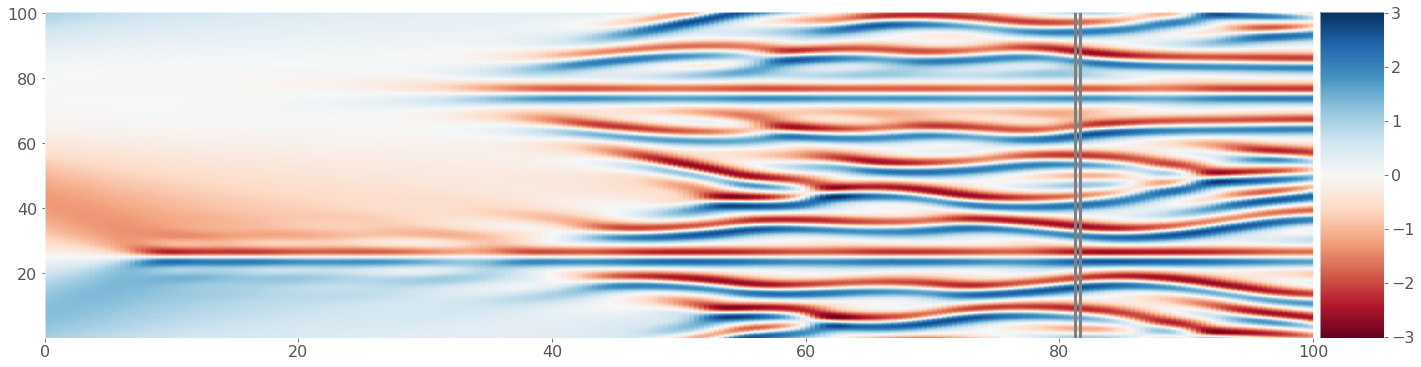

In [5]:
# plot solution u(t,r)
fig, ax  = plt.subplots(figsize=(24,6))
im       = ax.pcolormesh(T, R, U, cmap=mpl.cm.RdBu)
ax.vlines(params['ts'], R[0,0], R[0,-1], colors='gray')
colorbar(ax, im)
plt.show()

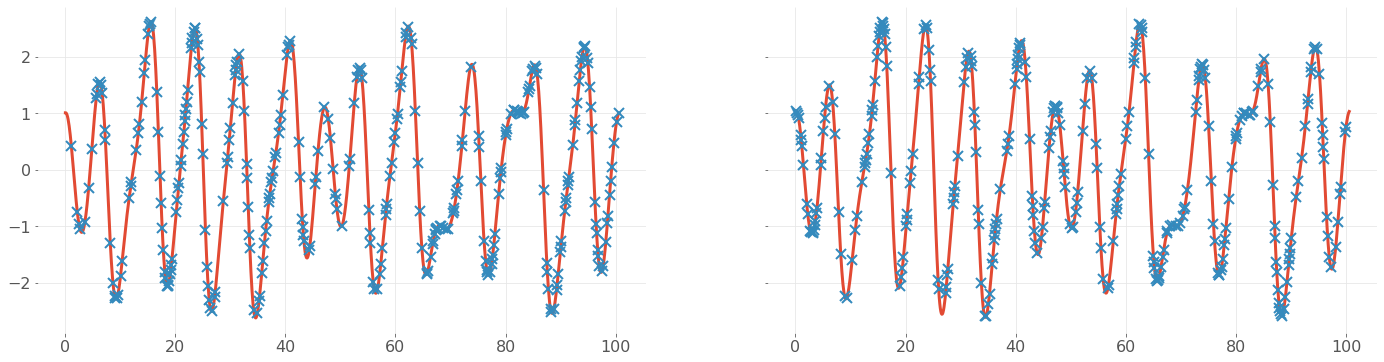

In [6]:
# plot training points and full solution at times t_{n-1} and t_{n}
fig, axes = plt.subplots(figsize=(24,6), ncols=2, sharex=True, sharey=True)
onp.random.seed(1256)
points    = [onp.ix_(onp.sort(onp.random.choice(params['n'], size=size, replace=False))) for size in [n0, n1]]
x_train   = [R[0,p][0] for p in points]
u_train   = [U[i,p][0] for i,p in zip(params['is'], points)]
for ax,u,xp,yp in zip(axes, [U[i0], U[i1]], x_train, u_train):
    ax.plot(R[0], u)
    ax.plot(xp, yp, ls='None', marker='x', mew=2)

We put a GP prior on $u_n$, and discretize the time derivative using a backward Euler step

\begin{align}\partial_t u + \lambda_1 u \,\partial_x u - \lambda_2 \partial_{xx} u &= 0\\
u^{n} + h \left[\lambda_1 u^{n}\,\partial_x - \lambda_2\partial_{xx}\right]u^{n} &= u^{n-1} \\
\mathcal{N}(u^{n}) &= u^{n-1} \\
\end{align}

Solutions at two times are related through a non-linear operator, which means that $u^{n-1}$ is not described by a GP. However, we can linearize this
\begin{align}
\mathcal{N}&\equiv 1 + h\left[\lambda_1 u^{n}\,\partial_x - \lambda_2\partial_{xx}\right] \\
&\simeq 1 + h\left[\lambda_1 u^{n-1}\,\partial_x - \lambda_2\partial_{xx}\right] = \mathcal{L}
\end{align}
With the $u^{n-1}$ appearing in $\mathcal{L}$ a frozen variable or constant function.

\begin{align}
\mathcal{L}_{x_0} u^{n}(x_0) = u^{(n-1)}(x_0)
\end{align}
where we use $x_0$ ($x_1$) to denote the arguments at time $t_{n-1}$ ($t_n$).

Because of the linearity, the joint prior for $u^{n-1}, u^{n}$ is now also a GP.

\begin{align}
\begin{pmatrix}
u^{n-1} \\
u^{n}
\end{pmatrix} &\sim \mathcal{GP}\left(0, \begin{pmatrix} \mathcal{L}_{x_0}\mathcal{L}_{x_0^\prime} k(x_0,x_0^\prime)  & \mathcal{L}_{x_0} k(x_0, x_1)\\
\mathcal{L}_{x_0} k(x_1, x_0) & k(x_1,x_1^\prime)
\end{pmatrix}\right)
\end{align}



Lets' summarize the corresponding (approximate) linearized operators for the Burgers', KdV, and KS equations

\begin{align}
\mathcal{L}^{\text{Burgers}} &= 1 + h\left[\lambda_1 u^{n-1} \partial_x - \lambda_2\partial_{xx}\right]\\
\mathcal{L}^{\text{KdV}}      &= 1 + h\left[\lambda_1 u^{n-1} \partial_x + \lambda_2\partial_{xxx}\right]\\
\mathcal{L}^{\text{KS}}      &= 1 + h\left[\lambda_1 u^{n-1} \partial_x + \lambda_2\partial_{xx} + \lambda_3\partial_{xxxx}\right]
\end{align}

Evaluating this by hand is out of the question...this is where jax's automatic differentiation capabilities come to the rescue

In [7]:
def L_Burgers(f,arg):
    if arg==0:
        return lambda x0,x1,θ,u0,u1,λ : f(x0,x1,θ,u0,u1,λ) + h*(λ[0]*u0*(grad(f,0)(x0,x1,θ,u0,u1,λ)) - λ[1]*(grad(grad(f,0), 0)(x0,x1,θ,u0,u1,λ)))
    else:
        return lambda x0,x1,θ,u0,u1,λ : f(x0,x1,θ,u0,u1,λ) + h*(λ[0]*u1*(grad(f,1)(x0,x1,θ,u0,u1,λ)) - λ[1]*(grad(grad(f,1), 1)(x0,x1,θ,u0,u1,λ)))
def L_KdV(f, arg):
    if arg==0:
        return lambda x0,x1,θ,u0,u1,λ : f(x0,x1,θ,u0,u1,λ) + h*(λ[0]*u0*(grad(f,0)(x0,x1,θ,u0,u1,λ)) + λ[1]*(grad(grad(grad(f,0),0),0)(x0,x1,θ,u0,u1,λ)))
    else:
        return lambda x0,x1,θ,u0,u1,λ : f(x0,x1,θ,u0,u1,λ) + h*(λ[0]*u1*(grad(f,1)(x0,x1,θ,u0,u1,λ)) + λ[1]*(grad(grad(grad(f,1),1),1)(x0,x1,θ,u0,u1,λ)))
def L_KS(f, arg):
    if arg==0:
        return lambda x0,x1,θ,u0,u1,λ : f(x0,x1,θ,u0,u1,λ) + h*(λ[0]*u0*(grad(f,0)(x0,x1,θ,u0,u1,λ)) +  λ[1]*(grad(grad(f,0), 0)(x0,x1,θ,u0,u1,λ)) + \
                                                                λ[2]*(grad(grad(grad(grad(f,0),0),0),0)(x0,x1,θ,u0,u1,λ)))
    else:
        return lambda x0,x1,θ,u0,u1,λ : f(x0,x1,θ,u0,u1,λ) + h*(λ[0]*u1*(grad(f,1)(x0,x1,θ,u0,u1,λ)) +  λ[1]*(grad(grad(f,1), 1)(x0,x1,θ,u0,u1,λ)) + \
                                                                λ[2]*(grad(grad(grad(grad(f,1),1),1),1)(x0,x1,θ,u0,u1,λ)))
Ls = {'Burgers':L_Burgers, 'KdV':L_KdV, 'KS':L_KS}
@jit
def K_NN(x0,x1,θ,u0,u1,λ):
    σ0,σ = np.exp(θ[0]),np.exp(θ[1])
    return 2.0/np.pi*np.arcsin(2.0*(σ0 + σ*x0*x1)/np.sqrt((1.0 + 2.0*(σ0 + σ*x0**2.0)) * (1.0 + 2.0*(σ0 + σ*x1**2))))
@jit
def K_SquareExp(x0,x1,θ,u0,u1,λ):
    logη2,logl2 = θ[0], θ[1]
    return np.exp(logη2 - 0.5*np.exp(-logl2)*dist(x0,x1)**2)

In [9]:
K  = K_SquareExp              # Note K_NN only tested with Burgers' equation
L  = Ls[params['name']]
LK = jit(L(K, 0))
LLK= jit(L(L(K, 1), 0))

map_K   = jit(vmap(K,  in_axes=(0,None,None,None,None,None)))
map_LK  = jit(vmap(LK, in_axes=(0,0,None,0,None,None)))
map_LLK = jit(vmap(LLK,in_axes=(0,0,None,0,0,None)))

x0,x1   = np.array(x_train[0]), np.array(x_train[1])
u0,u1   = np.array(u_train[0]), np.array(u_train[1])

def repeat_row(x,nrow):
    ncol = len(x)
    return np.broadcast_to(x,(nrow,ncol)).flatten()
def repeat_col(x,ncol):
    return np.repeat(x, ncol)

@jit
def get_K(p):
    θ,λ = p[:2],p[2:]
    Σ = np.zeros((n,n))
    Σ = jax.ops.index_add(Σ, jax.ops.index[:n0,:n0], map_LLK(repeat_col(x0,n0), repeat_row(x0,n0), θ, repeat_col(u0,n0), repeat_row(u0,n0), λ).reshape(n0,n0))
    Σ = jax.ops.index_add(Σ, jax.ops.index[:n0,n0:], map_LK(repeat_col(x0,n1), repeat_row(x1,n0), θ, repeat_col(u0,n1), None, λ).reshape(n0,n1))
    Σ = jax.ops.index_add(Σ, jax.ops.index[n0:,:n0], np.transpose(Σ[:n0,n0:]))
    Σ = jax.ops.index_add(Σ, jax.ops.index[n0:,n0:], map_K(x1,x1,θ,None,None,None))
    return Σ

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lib/xla_bridge.py:114: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


\begin{align}
\log{P(\theta | D, I)} &\propto -\frac{1}{2}\left[y^t K^{-1}(\theta) y + \log{\det{K(\theta)}} + n \log(2\pi)\right] 
+ \log{P(\theta| I)}
\end{align}

In [10]:
y     = np.concatenate([u0,u1])
noise = np.ones_like(y)*1.0e-8
@jit
def logGP(p):
    Σ = get_K(p)
    L = np.linalg.cholesky(Σ + np.diag(noise))
    v = np.linalg.solve(L, y)
    return (0.5*np.dot(v,v) + np.sum(np.log(np.diag(L))) + 0.5*n*np.log(2.0*np.pi)) +  len(p)*np.log(10.0)

def learn(params, λval=2):
    def minimize(init):
        opt1 = optimize.minimize(logGP, init, method='Nelder-Mead', options={'maxiter':1000, 'disp':0}) # downhill simplex
        opt2 = optimize.minimize(logGP, opt1['x'], method='BFGS', options={'maxiter':1000, 'disp':0})
        return [opt1, opt2]
    if params['name'] == 'KdV' or params['name'] == 'Burgers':
        return minimize([0.0, 0.0, λval, λval])
    elif params['name'] == 'KS':
        return minimize([0.0, 0.0, λval, λval, λval])
    else:
        return
opt = learn(params)

In [11]:
for o in opt:
    print(f'\t chi2 = {o["fun"]:12.6e}, niter = {o["nit"]:5d}, Converged = {o["success"]:6b} : {o["message"]}')
    print('\t\t x = ', o['x'])
ihess = opt[-1]['hess_inv']
for i,a in enumerate(opt[-1]['x'][2:]):
    print('λ_{0:1d} = {1:.3f} +/- {2:.3e}'.format(i, a, 2*onp.sqrt(ihess[i][i]*2)))

	 chi2 = 7.215301e+02, niter =   470, Converged =      1 : Optimization terminated successfully.
		 x =  [ 0.80524308 -1.62586046  0.98586489  1.02454959  0.98712323]
	 chi2 = 7.215225e+02, niter =     3, Converged =      0 : Desired error not necessarily achieved due to precision loss.
		 x =  [ 0.80518076 -1.62584683  0.98584889  1.02452852  0.98708764]
λ_0 = 0.986 +/- 8.772e-01
λ_1 = 1.025 +/- 2.440e+00
λ_2 = 0.987 +/- 2.651e+00


Note that the BFGS optimization does not converge. For better results we should compute the gradient of $\log P$, in order to feed this into the minimization routine. Using jax this should not be too difficult...